In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def gaussian_filter(sigma, kernel_size = 0):
    
    # set kernel size to be 2 x (sigma * 3)
    if(kernel_size == 0):
        kernel_size = 1 + 2 * (np.ceil(sigma) * 3)
        
    half_kernel_size = (kernel_size - 1)/2
    

Read image and perform smoothing

3200.0
21000.0


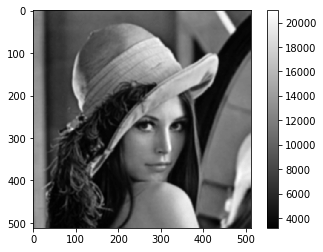

In [21]:
im = cv2.imread("lena.png")
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im = cv2.GaussianBlur(im, (7,7), 2)
im = im.astype(np.float64)
im = im * 100
plt.figure()
plt.imshow(im, cmap="gray")
plt.colorbar()

print(np.amin(im))
print(np.amax(im))

Compute edge magnitude and gradient map

1.0


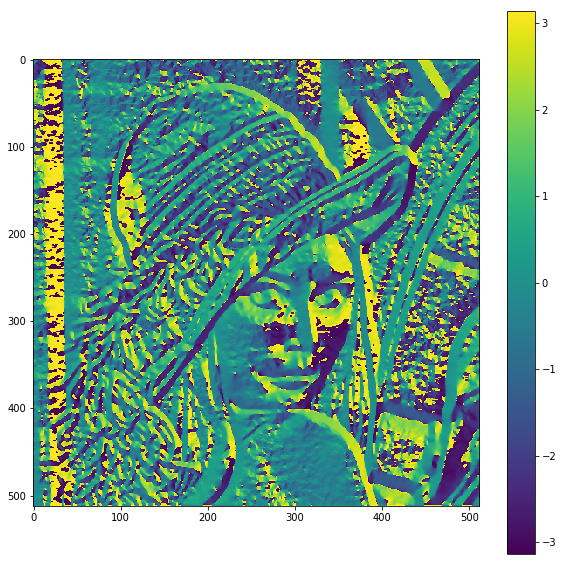

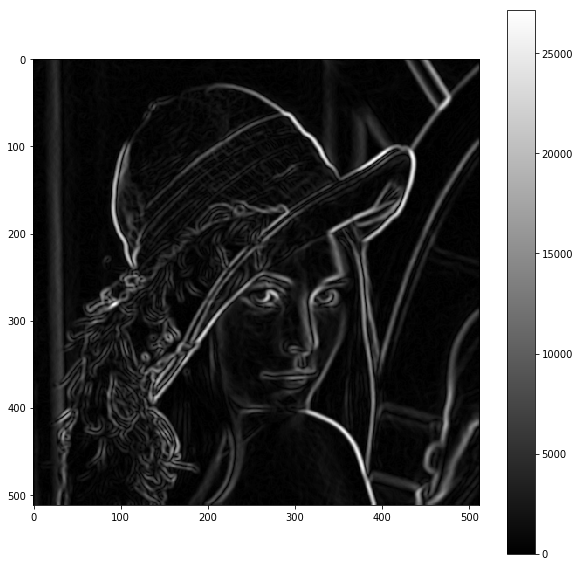

In [26]:
grad_x = cv2.Sobel(im, cv2.CV_64F, 1, 0, 3)
grad_y = cv2.Sobel(im, cv2.CV_64F, 0, 1, 3)
grad_mag = np.sqrt(grad_x * grad_x + grad_y * grad_y)
grad_phase = np.arctan2(grad_y, grad_x)

plt.figure(figsize=(10,10))
plt.imshow(grad_phase)
plt.colorbar()

plt.figure(figsize=(10,10))
plt.imshow(grad_mag, cmap="gray")
plt.colorbar()

grad_mag = (grad_mag - np.amin(grad_mag)) / (np.amax(grad_mag) - np.amin(grad_mag))
print(np.amax(grad_mag))

Perform non-maximum suppression. For each pixel, we check its neighbour along the direction of the gradient and suppress the pixel if it is not the maximum of the three. 

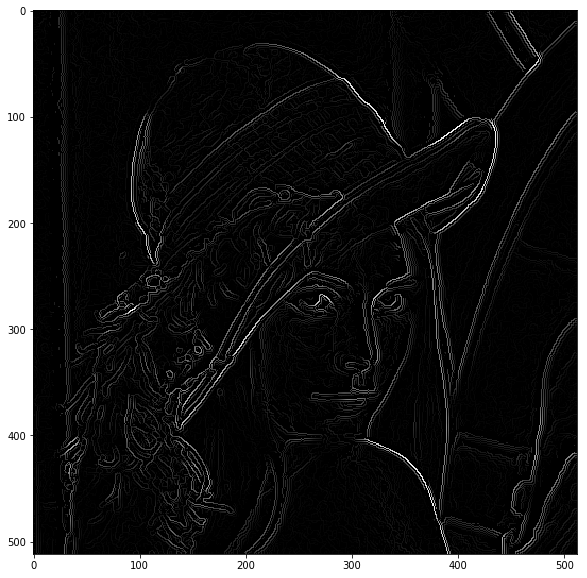

In [27]:
PI = 3.142
def return_neighbour_id(phase):
        
    if((phase >  -PI/8 and phase  <   PI/8) or (phase >   7*PI/8 or  phase < -7*PI/8)): 
        return ([ 0,-1], [ 0,1])
    if((phase >=   PI/8 and phase < 3*PI/8) or (phase >= -7*PI/8 and phase < -5*PI/8)): 
        return ([-1,-1], [ 1,1])
    if((phase >= 3*PI/8 and phase < 5*PI/8) or (phase >= -5*PI/8 and phase < -3*PI/8)):
        return ([-1, 0], [ 1,0])
    if((phase >= 5*PI/8 and phase < 7*PI/8) or (phase >= -3*PI/8 and phase < -1*PI/8)):
        return ([ 1,-1], [-1,1]) 
    
def non_max_suppress(grad_mag, grad_phase):
    
    grad_mag_suppressed = np.copy(grad_mag)

    rows, cols = np.nonzero(grad_mag)    
    for r,c in zip(rows,cols):
        n1, n2 = return_neighbour_id(grad_phase[r,c])
        
        if ((grad_mag_suppressed[r,c] > grad_mag_suppressed[r+n1[0],c+n1[1]]) and (grad_mag_suppressed[r,c] > grad_mag_suppressed[r+n2[0],c+n2[1]])):
            continue
        else:
            grad_mag_suppressed[r,c] = 0
            
    return grad_mag_suppressed

grad_mag_suppressed = non_max_suppress(grad_mag, grad_phase)
plt.figure(figsize=(10,10))
plt.imshow(grad_mag_suppressed, cmap="gray")

Perform hysteresis thresholding. We remove all pixels whose intensity is below L2. We then perform region growing from pixels whose intensity is at least L1 and into pixels whose intensity are at least L2. L1 > L2.

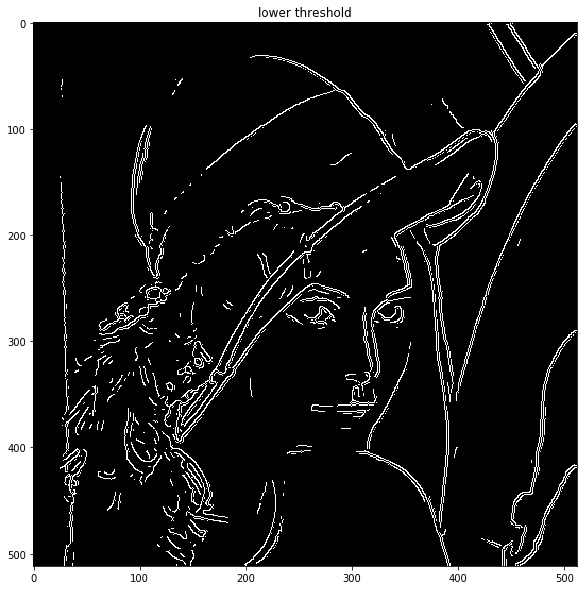

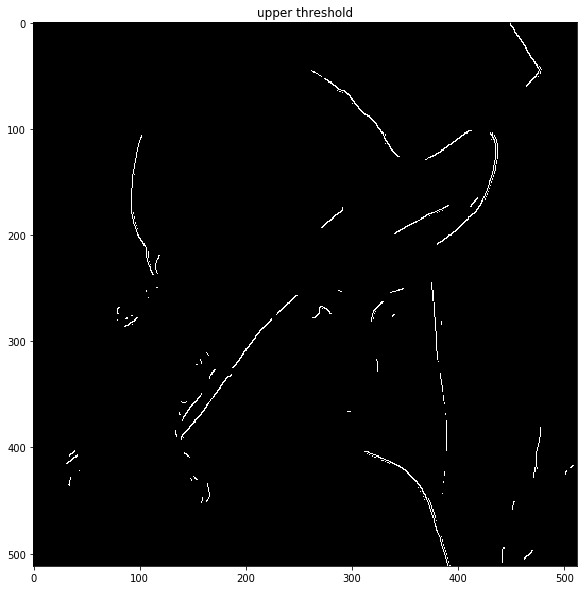

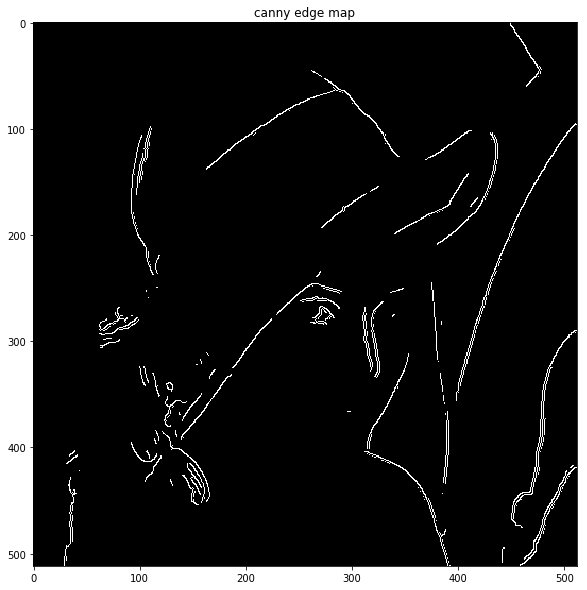

In [29]:
def visit(r,c, lower, canny):
    
    # Check neighbouring nodes
    for u in range(-1,2):
        for v in range(-1,2):
            
            # ignore borders
            if (r + u <= 0 or c + v <= 0 or r + u >= np.shape(lower)[0] or c + v >= np.shape(lower)[1]):
                continue
                
            if (lower[r+u,c+v] == 1 and canny[r+u,c+v] == 0):
                canny[r+u,c+v] =  1
                visit(r+u,c+v,lower,canny)

def hysteresis_thresholding(grad_mag_suppressed, l1, l2):
    
    lower = np.copy(grad_mag_suppressed)
    lower[lower < l1] = 0
    lower[lower >= l1] = 1
    
    plt.figure(figsize=(10,10))
    plt.title("lower threshold")
    plt.imshow(lower,cmap="gray")
        
    canny = np.copy(grad_mag_suppressed)        
    canny[canny < l2] = 0       
    canny[canny >= l2] = 1
            
    plt.figure(figsize=(10,10))
    plt.title("upper threshold")
    plt.imshow(canny,cmap="gray")
        
    # grow
    rows, cols = np.nonzero(canny)    
    for r,c in zip(rows,cols):        
        visit(c, r, lower, canny);
        
    return canny

canny = hysteresis_thresholding(grad_mag_suppressed, 0.2, 0.5)
plt.figure(figsize=(10,10))
plt.title("canny edge map")
plt.imshow(canny,cmap="gray")